In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
% matplotlib inline

## Generate data, find basis

In [2]:
def generate_data(P, M, N):
    res = [[0 for j in range(P)] for i in range(M)]
    for u in range(P):
        t = u*2*np.pi/P
        for m in range(M):
            x = m*2*np.pi/M
            tmp = [np.sin(k*(x-t))/k for k in range(1, N+1)]
            res[m][u] = np.mean(tmp)
    
    return np.array(res)

In [3]:
X = generate_data(64, 64, 3)
np.linalg.matrix_rank(X)

6

In [4]:
U, s, V = np.linalg.svd(X)  # calculate PCA eigenvectors

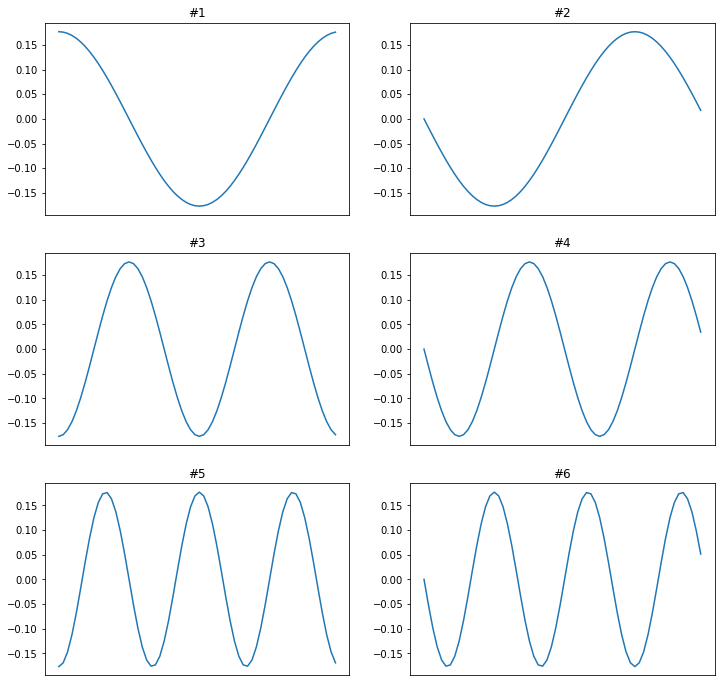

In [5]:
# plot the first 6 basis
fig = plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(3,2, i+1)
    plt.plot(U[:, i])
    plt.tick_params(bottom='off', labelbottom='off')
    plt.title('#%d' %(i+1))
plt.show()

## fix gappy data with good basis

In [6]:
def fix_single_pattern(U, m, x):
    '''
    This function takes a set of D good basis and fix one single gappy pattern
    :param U: first D basis from SVD left singular matrix
    :param x: gappy data which needs to be reconstructed
    :param m: gappy mask for x, 0 if missing data else 1
    :return: fixed x
    '''
    m = m.reshape(m.shape[0], 1)
    x = x.reshape(x.shape[0], 1) * m
    # first calculate alpha_hat (gappy_alpha)
    D = U.shape[1]
    M = np.array([[np.sum(i*j*np.squeeze(m)) for j in U.T] for i in U.T])  # M is a DxD matrix
    f = U.T@x
    gappy_alpha = np.linalg.inv(M)@f
    
    # gappy reconstruction
    g = U@gappy_alpha
    
    return x + g*(m == 0)

In [7]:
def create_gappy_single(x, p):
    '''
    This function randomly generate a gappy pattern from x
    :param x: complete data x
    :param p: percentage of missing entries
    :return: gappy x filled with 0 and the mask
    '''
    n = int(x.shape[0] * p)  # the number of missing entries
    missing_ind = random.sample(range(x.shape[0]), n)
#     print(missing_ind)
    m = [0 if i in missing_ind else 1 for i in range(x.shape[0])]
    m = np.array(m).reshape(x.shape)
    
    return x*m, m

In [8]:
def error_of_fixing(complete_x, p, U):
    xg, m = create_gappy_single(complete_x, p)
    x_fix = fix_single_pattern(U, m, xg)
    return np.linalg.norm(complete_x-x_fix) / np.linalg.norm(complete_x)

In [9]:
target_pattern = X[:, 0]
errors = []
for p in np.arange(0.05, 1.0, 1/64):
    errors.append(error_of_fixing(target_pattern, p, U[:, :6]))

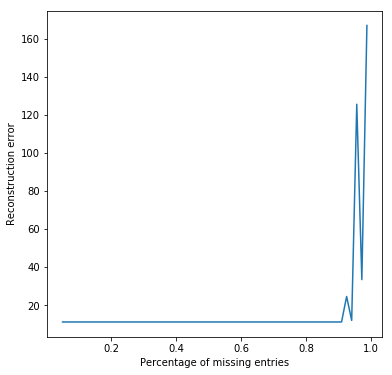

In [10]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(0.05, 1.0, 1/64), errors)
plt.xlabel('Percentage of missing entries')
plt.ylabel('Reconstruction error')
plt.show()

## fix gappy data with no good basis

In [11]:
def initial_fix(x, m):
    '''
    :param x: gappy data
    :param m: mask having the same shape of x
    :return: initially fixed gappy data
    '''
    x = x.astype(np.float32)
    for i in range(m.shape[0]):
        known_mean = np.mean(x[i, m[i] != 0])
        x[i] = x[i] * m[i] + (m[i] == 0) * known_mean
    
    return x

In [12]:
def general_gappy_fix(x, m, D, e, iter_max=100):
    '''
    This function fixes gappy data without known good basis
    :param x: gappy data that is already initially fixed
    :param m: mask having the same shape of x
    :param D: rank of non-gappy data
    :param e: stopping criterion
    :param iter_max: maximum number of iteration in case algorithm does not converge
    :return: fixed gappy data and the number of iterations
    '''
    U, s, V = np.linalg.svd(x)
    s_pre = s[:D]
    s_new = s_pre + e + 1 # initialize s_new so that the first iteration always run
    x_new = None
    for step in range(iter_max):
        if np.sqrt(np.linalg.norm(s_new**2 - s_pre**2)) <= e:
            break
        Ud = U[:, :D]
        x_new = []
        for i in range(x.shape[1]):
            x_new.append(fix_single_pattern(Ud, m[:, i], x[:, i]).squeeze())
        x_new = np.array(x_new).T
        x = x_new
        U, s, V = np.linalg.svd(x)
#         print(s)
        s_pre = s_new
        s_new = s[:D]
        
    return x, step

In [13]:
def create_gappy_ensemble(x, p):
    '''
    This function randomly generate an ensemble of gappy patterns from x
    :param x: complete data x
    :param p: percentage of missing entries
    :return: gappy x filled with 0 and the mask
    '''
    n = int(x.shape[0] * x.shape[1] * p)  # the number of missing entries
    missing_ind_flat = random.sample(range(x.shape[0] * x.shape[1]), n)
    m = np.ones(x.shape)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if m.shape[1] * i + j in missing_ind_flat:
                m[i][j] = 0
    
    return x*m, m

In [27]:
# Part D. repair the ensemble
xg, m = create_gappy_ensemble(X, 0.2)
xg = initial_fix(xg, m)
x_fixed, step = general_gappy_fix(xg, m, 6, 0.01)
print(np.linalg.norm(X-x_fixed) / np.linalg.norm(X))
print(X[m[:,0]==0,0])
print(x_fixed[m[:,0]==0,0])
m[:, 0]

2.5085403892e-06
[ 0.47291989  0.47351178  0.45281316  0.42166123  0.14760301 -0.03241118
 -0.06297956 -0.12913006 -0.15589693 -0.17076234 -0.4062866  -0.09744129]
[ 0.47291964  0.47351171  0.45281307  0.42166113  0.14760319 -0.03241126
 -0.06297967 -0.12912921 -0.15589684 -0.17076257 -0.40628661 -0.09744129]


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.])

In [15]:
# Part E. 
def convergence_rate_with_percent(p, max_iter):
    xg, m = create_gappy_ensemble(X, p)
    xg = initial_fix(xg, m)
    x_fixed, step = general_gappy_fix(xg, m, 6, 0.01, max_iter)
    
    return step

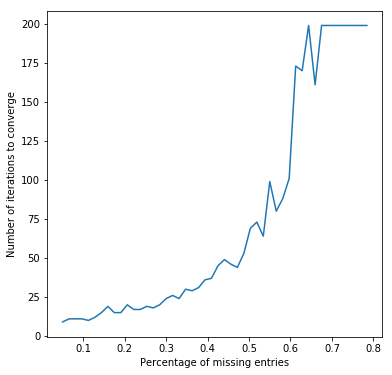

In [16]:
conv_rates = []
for p in np.arange(0.05, 0.8, 1/64):
    conv_rates.append(convergence_rate_with_percent(p, 200))
plt.figure(figsize=(6,6))
plt.plot(np.arange(0.05, 0.8, 1/64), conv_rates)
plt.xlabel('Percentage of missing entries')
plt.ylabel('Number of iterations to converge')
plt.show()